In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import scaling_lib.ftutils_torch as ftutils
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
import torchvision
from torchvision import transforms

In [3]:
from scaling_lib.split_step_solver import BPMSplitStepSolver
from scaling_lib.waveguide import Waveguide
from scaling_lib.helpers import smoothen1d, smoothen2d, gaussian_beam, add_absorbing_boundary, timestring, make_boxed_modes
from scaling_lib.mode_solver import solve_modes
from scaling_lib.pat import make_pat_func
from scaling_lib import pnn_utils 

# Parameters

In [4]:
Nmodes_in = 49
Nmodes_out = 10

# waveguide parameters
λ0 = 1.55 # free-space wavelength, all lengths are in um
k0 = 2*np.pi/λ0
neff = 1.8 # effective index of slab mode
delta_n_val = 1.0e-3 # maximal refractive index change

# x-axis
Lx = 2000 # width of simulation area (transverse dimension)
Nx = 2**11 # number of pixels in transverse dimensions
dx = Lx/(Nx-1) # stepsize in transverse dimension
x_axis = ftutils.ft_t_axis(Nx, dx)

# z-axis
dz = 50 # propagation step in z-direction
Lz = 10000 # length of device in propagation-direction
Nz = int(np.floor(Lz/dz))
z_axis = (torch.arange(Nz)+1)*dz

# mode properties
input_x_min = -200 # center position of leftmost mode
input_x_max = 200 # center position of rightmost mode
output_x_max = 300 # center position of rightmost mode
w0 = 6 # beam waist of gaussian mode

# training parameters
iterations = 3 # number of training epochs
lr = 3e-2 # learning rate
gamma = 0.95
batch_size = 64
device = 'cuda'

# add absorbing boundary conditions
background_delta_n = torch.zeros(Nx, dtype = torch.complex64)
background_delta_n = add_absorbing_boundary(x_axis, background_delta_n, k0, abs_width=400, sigma_max = 0.10)
# The waveguide class is just a convenient way of storing all parameters associated with the waveguide, it does not do anything beyond that
wg = Waveguide(neff, x_axis, z_axis, device = device)

## Define input and output modes

In [5]:
# We use Gaussian beams as our input "modes" and boxes as the output "modes"
input_modes = torch.vstack([gaussian_beam(x_axis, mu, w0) for mu in np.linspace(input_x_min, input_x_max, Nmodes_in)])
output_modes = make_boxed_modes(x_axis, N=Nmodes_out, xmode_out_lim=output_x_max)

C:\Users\marti\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:5484: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[1:N+1, 1] = dep1slice
C:\Users\marti\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\marti\anaconda3\Lib\site-packages\torch\_tensor.py:1151: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


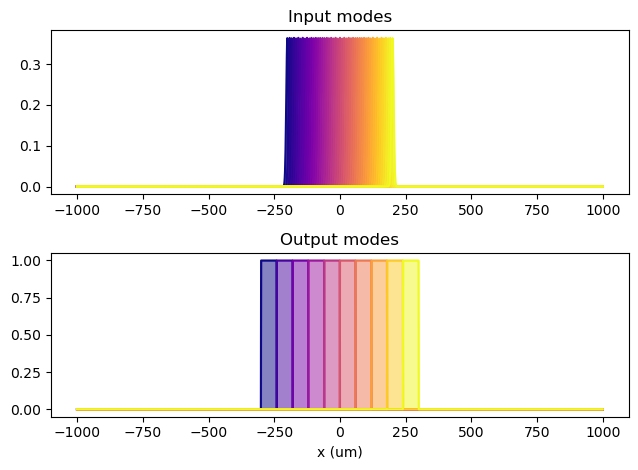

In [6]:
plt.subplot(2,1,1)
for ind_mode, mode in enumerate(input_modes):
    plt.fill_between(x_axis, mode, label = f'Input {ind_mode}', color = cm.plasma(ind_mode/(Nmodes_in-1)), alpha = 0.5)
    plt.plot(x_axis, mode, color = cm.plasma(ind_mode/(Nmodes_in-1)))

plt.title('Input modes')

plt.subplot(2,1,2)
for ind_mode, mode in enumerate(output_modes):
    plt.fill_between(x_axis, mode, label = f'Output {ind_mode}', color = cm.plasma(ind_mode/(Nmodes_out-1)), alpha = 0.5)
    plt.plot(x_axis, mode, color = cm.plasma(ind_mode/(Nmodes_out-1)))

plt.xlabel('x (um)')
plt.title('Output modes')

plt.tight_layout()

## Load MNIST

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),                      # convert to tensor, scales to [0,1]
])

train_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True 
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False
)

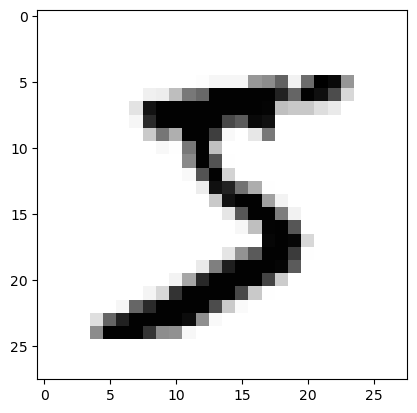

In [8]:
x,y = train_dataset[0]
plt.imshow(x[0], cmap=cm.Grays)

## Create trainable 2D waveguide class as pytorch.nn.Module 

In [9]:
class SingleMult(nn.Module):
    def __init__(self, factor_init=1.0):
        super().__init__()
        self.factor = nn.Parameter(factor_init*torch.tensor(factor_init))
        
    def forward(self, x):
        self.x = x
        self.out = x*self.factor 

        self.save_dict = dict(inp=x.detach(), out=self.out.detach())
        
        return self.out

In [10]:
def avgpool_downsampling(x):
    x = F.avg_pool2d(x, kernel_size=4, stride=4)
    x = x[:, 0, :, :].flatten(start_dim = 1)
    return x

In [11]:
class TDwgNet(nn.Module):
    def __init__(self, solver, wg, delta_n_val, input_modes, output_modes, device, mode = 'insilico', wg_backward = None, res_x = 6, res_z =6):
        super(TDwgNet, self).__init__()
        self.device = device
        
        mod = 0.5*torch.ones([wg.Nz, wg.Nx], requires_grad=True, dtype=torch.float32).to(self.device)
        self.mod = pnn_utils.Parameter(mod, limits=[0.05, 0.95]) 
        self.delta_n_val = delta_n_val
        self.scale_x = res_x # resolution limit in x-direction
        self.scale_z = res_z # resolution limit in z-direction
        
        self.input_modes = input_modes.to(dtype=torch.complex64).to(self.device)
        self.output_modes = output_modes.to(dtype=torch.float32).to(self.device)
        
        self.wg = wg
        self.solver = solver
        
        if wg_backward: self.wg_backward = wg_backward
        else: self.wg_backward = wg
            
        if mode == 'pat': self.f_pat = make_pat_func(self.forward_internal, self.backward_internal)
        if mode == 'insilico': self.f_pat = self.forward_internal
            
        self.mult = SingleMult(0.5)

    def forward(self, x):
        a_out = self.f_pat(x)
        return a_out

    def forward_internal(self, x, monitor = False):
        mod = self.mod
        mod = mod.clip(0., 1.)
        mod = smoothen2d(self.wg.x_axis, self.wg.z_axis, mod, scale_x = self.scale_x, scale_z = self.scale_z)

        x = avgpool_downsampling(x).to(torch.complex64)
        inputs = x.to(self.device) @ self.input_modes
        
        delta_n = self.wg.background_delta_n + self.delta_n_val*mod
        output_beams = self.solver.run_simulation(inputs, delta_n, monitor)
        output_intensity = output_beams.abs().square()
        
        a_out = output_intensity@self.output_modes.T*self.wg.dx
        return self.mult(a_out)

## Training loop

In [12]:
bpmsolver = BPMSplitStepSolver(x_axis, z_axis, neff)
tdwg_pnn = TDwgNet(bpmsolver, wg, delta_n_val, input_modes, output_modes, device=device)
optimizer = optim.Adam(tdwg_pnn.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
tdwg_pnn.train()

TDwgNet(
  (mult): SingleMult()
)

In [13]:
print_interval = 100

loss_list = []
n = len(tdwg_pnn.input_modes)  # length of the original vector
indices = np.arange(n)
batch_indices = np.array_split(indices, np.ceil(n / batch_size))  # Split into subvectors

for ind_epoch in range(iterations):

    for ind_batch, batch in enumerate(train_loader):
        optimizer.zero_grad()
        
        x, targets = batch
        targets = targets.to(device)
        
        y_out = tdwg_pnn.forward(x)
        logits = F.log_softmax(y_out, dim=1)
        l_objective = F.nll_loss(logits, targets)
        l_lagrange = pnn_utils.lagrangian(tdwg_pnn, lag_amp = 2, factor = 20)
        l = l_objective + l_lagrange 
        l.backward()
        
        optimizer.step()
        loss_list.append(l.detach().cpu().data)

        if ind_batch % print_interval == 0:
            preds = y_out.argmax(dim=1)
            accuracy = (preds == targets).float().mean().item()
            print(timestring() + f"--Epoch: {ind_epoch}, Batch: {ind_batch} Loss: {l.detach().cpu().data:.5f}, Batch accuracy: {accuracy*100:.2f}%")
            
    scheduler.step()

C:\Users\marti\OneDrive - Yale University\Work\Github\2D-waveguide-demo-code\scaling_lib\split_step_solver.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dz = torch.tensor(self.dz, device=device, dtype=delta_n.dtype)


2025-09-22--12-57-20--Epoch: 0, Batch: 0 Loss: 2.29826, Batch accuracy: 15.62%
2025-09-22--12-57-30--Epoch: 0, Batch: 100 Loss: 0.79913, Batch accuracy: 85.94%
2025-09-22--12-57-40--Epoch: 0, Batch: 200 Loss: 0.70173, Batch accuracy: 82.81%
2025-09-22--12-57-49--Epoch: 0, Batch: 300 Loss: 0.71341, Batch accuracy: 78.12%
2025-09-22--12-57-59--Epoch: 0, Batch: 400 Loss: 0.75987, Batch accuracy: 82.81%
2025-09-22--12-58-09--Epoch: 0, Batch: 500 Loss: 0.59979, Batch accuracy: 90.62%
2025-09-22--12-58-18--Epoch: 0, Batch: 600 Loss: 0.58077, Batch accuracy: 84.38%
2025-09-22--12-58-28--Epoch: 0, Batch: 700 Loss: 0.67468, Batch accuracy: 76.56%
2025-09-22--12-58-37--Epoch: 0, Batch: 800 Loss: 0.51661, Batch accuracy: 85.94%
2025-09-22--12-58-47--Epoch: 0, Batch: 900 Loss: 0.48970, Batch accuracy: 87.50%
2025-09-22--12-58-51--Epoch: 1, Batch: 0 Loss: 0.43010, Batch accuracy: 84.38%
2025-09-22--12-59-00--Epoch: 1, Batch: 100 Loss: 0.70112, Batch accuracy: 79.69%
2025-09-22--12-59-10--Epoch: 1, 

Text(0, 0.5, 'Loss')

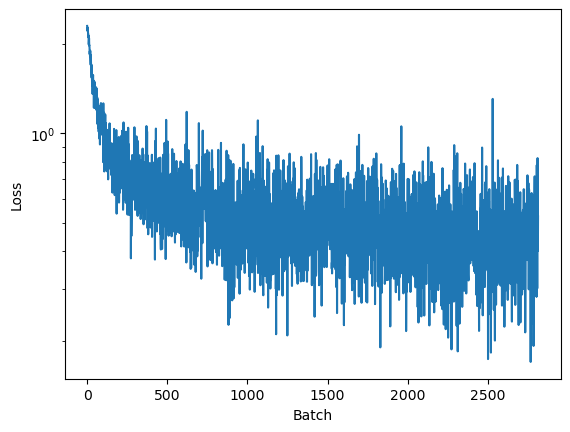

In [14]:
plt.plot(loss_list)
plt.yscale('log')
plt.xlabel('Batch')
plt.ylabel('Loss')

In [15]:
# Get test accuracy
tdwg_pnn.eval()  # set to eval mode
all_outputs = []
all_targets = []

with torch.no_grad():
    for x, targets in test_loader:
        y_pred = tdwg_pnn.forward_internal(x, monitor=True)
        
        all_outputs.append(y_pred)
        all_targets.append(targets.to(device))

# stack all batches
all_outputs = torch.cat(all_outputs, dim=0)   # [N, 10]
all_targets = torch.cat(all_targets, dim=0)   # [N] or [N, 10] if one-hot

# predicted classes
preds = all_outputs.argmax(dim=1)

# accuracy
accuracy = (preds == all_targets).float().mean().item()
print(f"Test accuracy: {accuracy*100:.2f}%")

Test accuracy: 88.41%


## Plot results

In [25]:
def plot_delta_n(z_axis, x_axis, delta_n, vmax):
    figsize_deltan = (2*3, 2*1.5*3/5)
    fig_main, ax = plt.subplots(figsize=figsize_deltan, dpi=200)
    img = plt.pcolormesh(z_axis/1000, x_axis, np.real(delta_n.T), cmap="Greens", vmax=vmax, vmin=0)
    plt.ylim(-300, 300)
    plt.xlabel("z (mm)")
    plt.ylabel("x (um)")
    plt.title(r"$\Delta n(x, z)$")
    cbar = plt.colorbar()
    cbar.set_label(r'$\Delta n$', rotation=270, labelpad=5)  # Reduced labelpad from 15 to 5

    visible_ticks = [tick for tick in ax.get_xticks() if ax.get_xlim()[0] <= tick <= ax.get_xlim()[1]]
    visible_ticks = [0] + visible_ticks  # Add 0 to the visible ticks
    ax.set_xticks(visible_ticks)

    plt.show()

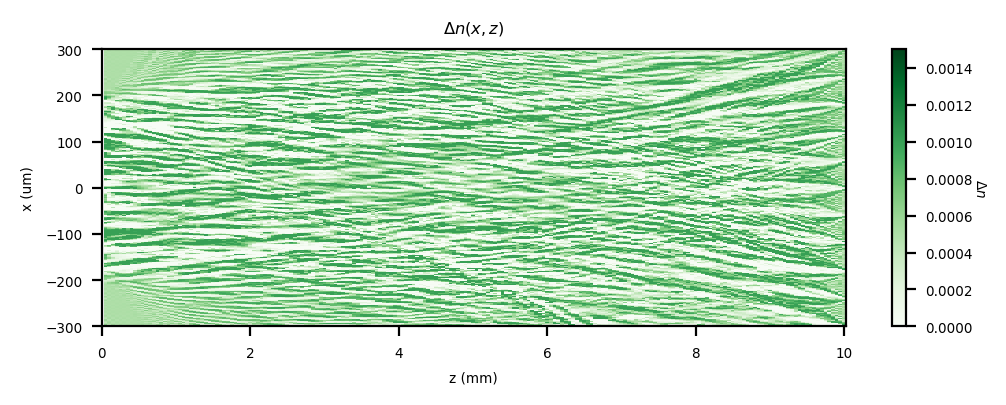

In [26]:
delta_n_inv = delta_n_val*(torch.clip(tdwg_pnn.mod.detach().cpu(), 0., 1.))
plot_delta_n(wg.z_axis, wg.x_axis, delta_n_inv, 1.5*delta_n_val)

In [29]:
def plot_intensity(z_axis, x_axis, Imat_x):
    figsize_deltan = (2*3, 2*1.5*3/5)
    fig_main, ax = plt.subplots(figsize=figsize_deltan, dpi=200)
    img = plt.pcolormesh(z_axis/1000, x_axis, Imat_x, cmap="Reds")
    plt.ylim(x_axis.min(), x_axis.max())
    plt.xlabel("z (mm)")
    plt.ylabel("x (um)")
    plt.title(r"$I(x, z)$")
    plt.colorbar()
    plt.ylim(-300, 300)

    plt.show()

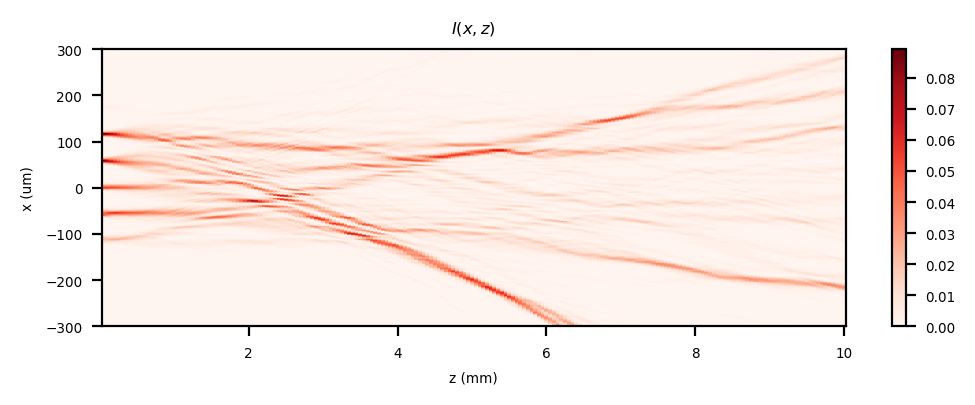

In [30]:
ind =  0
Emat_x = tdwg_pnn.solver.Emat_x[:,ind].cpu().detach()
Imat_x = Emat_x.abs().square()
z_list = z_axis[::tdwg_pnn.solver.Ncom]
plot_intensity(z_list, x_axis, Imat_x.T)

## Confusion matrix

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [21]:
plt.rcParams['font.size'] = 4.9

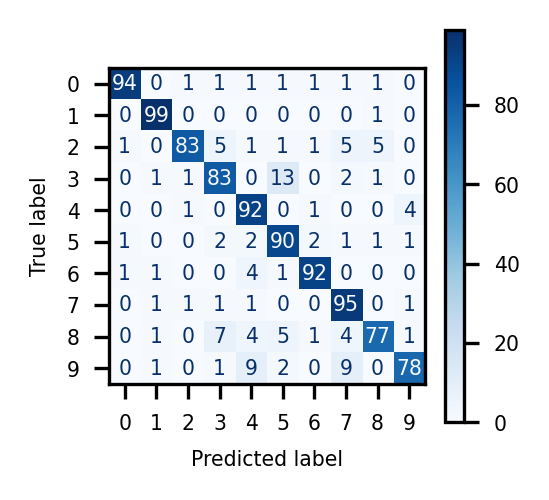

In [22]:
conf = confusion_matrix(all_targets.cpu(), preds.cpu())
conf = conf/np.sum(conf, axis=1)*100
conf = np.round(conf).astype(int)

disp = ConfusionMatrixDisplay(conf)

size = 1.7
fig = plt.figure(figsize=(size, size), dpi=300)
ax = plt.gca()
disp.plot(ax=ax, cmap = 'Blues') 